In [1]:
# USAGE
# python predict.py
# import the necessary packages
import config
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import os

In [2]:
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()

In [5]:
def make_predictions(model, imagePath):
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		# load the image from disk, swap its color channels, cast it
		# to float data type, and scale its pixel values
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image.astype("float32") / 255.0
		# resize the image and make a copy of it for visualization
		image = cv2.resize(image, (128, 128))
		orig = image.copy()
		# find the filename and generate the path to ground truth
		# mask
		filename = imagePath.split(os.path.sep)[-1]
        
		filename_without_ext = os.path.splitext(filename)[0]
		filename = filename_without_ext + '.png'

        
		groundTruthPath = os.path.join(config.MASK_DATASET_PATH,
			filename)
		# load the ground-truth segmentation mask in grayscale mode
		# and resize it
		gtMask = cv2.imread(groundTruthPath, 0)
		gtMask = cv2.resize(gtMask, (config.INPUT_IMAGE_HEIGHT,
			config.INPUT_IMAGE_HEIGHT))
        		# make the channel axis to be the leading one, add a batch
		# dimension, create a PyTorch tensor, and flash it to the
		# current device
		image = np.transpose(image, (2, 0, 1))
		image = np.expand_dims(image, 0)
		image = torch.from_numpy(image).to(config.DEVICE)
        
        # Make the prediction
		predMask = model(image).squeeze()

        # Apply softmax to the prediction (dim=1 for class dimension)
		predMask = torch.softmax(predMask, dim=1)

        # Convert probabilities to class labels
		predMask = torch.argmax(predMask, dim=0)

        # Convert the tensor to a NumPy array
		predMask = predMask.cpu().numpy()

        # Optionally, convert class labels to a color map for visualization (if needed)
        # predMask = color_map(predMask, num_classes=3)

        # Prepare a plot for visualization
		prepare_plot(orig, gtMask, predMask)
        

[INFO] loading up test image paths...
[INFO] load up model...
failed with /Users/Gabriel/MResMedicalImaging/RESEARCH_PROJECT/BasicSeg/dataset/oxford-iiit-pet/images/Ragdoll_79.jpg
failed with /Users/Gabriel/MResMedicalImaging/RESEARCH_PROJECT/BasicSeg/dataset/oxford-iiit-pet/images/Ragdoll_116.jpg
failed with /Users/Gabriel/MResMedicalImaging/RESEARCH_PROJECT/BasicSeg/dataset/oxford-iiit-pet/images/yorkshire_terrier_168.jpg
failed with /Users/Gabriel/MResMedicalImaging/RESEARCH_PROJECT/BasicSeg/dataset/oxford-iiit-pet/images/Abyssinian_145.jpg
failed with /Users/Gabriel/MResMedicalImaging/RESEARCH_PROJECT/BasicSeg/dataset/oxford-iiit-pet/images/yorkshire_terrier_25.jpg
failed with /Users/Gabriel/MResMedicalImaging/RESEARCH_PROJECT/BasicSeg/dataset/oxford-iiit-pet/images/shiba_inu_25.jpg
failed with /Users/Gabriel/MResMedicalImaging/RESEARCH_PROJECT/BasicSeg/dataset/oxford-iiit-pet/images/Siamese_42.jpg
failed with /Users/Gabriel/MResMedicalImaging/RESEARCH_PROJECT/BasicSeg/dataset/oxfo

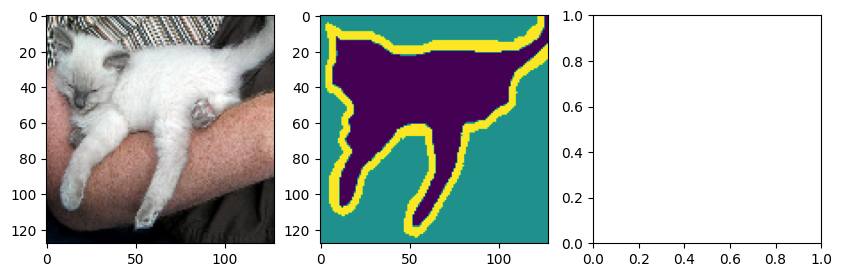

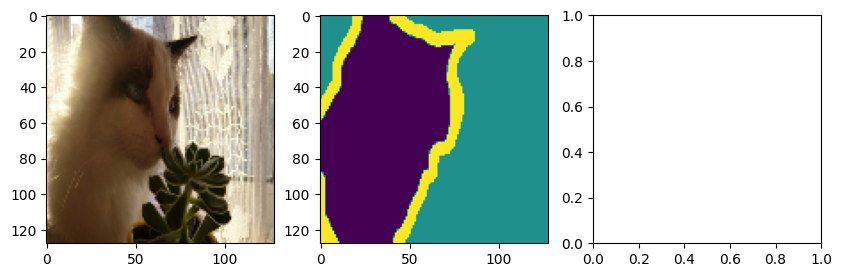

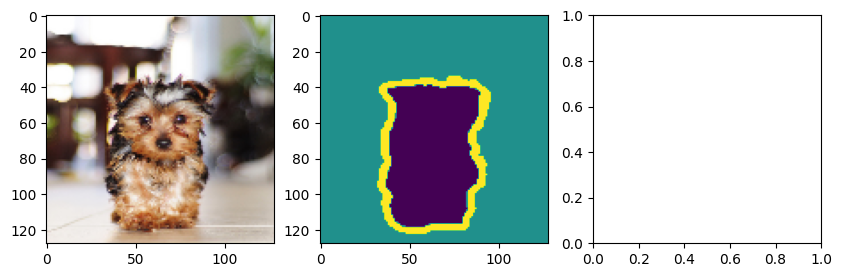

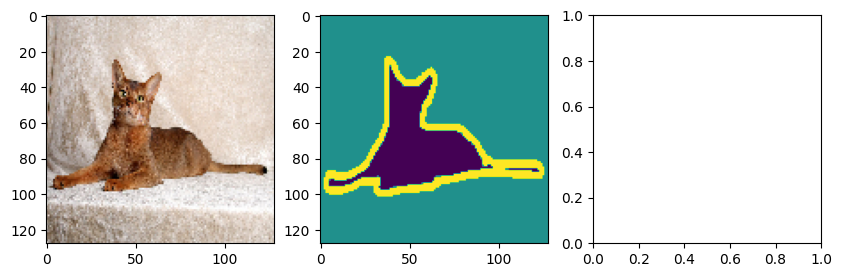

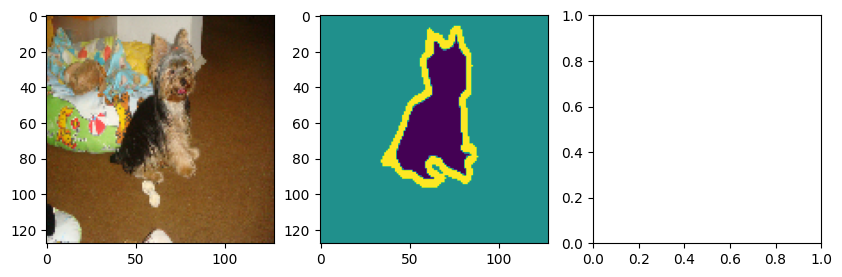

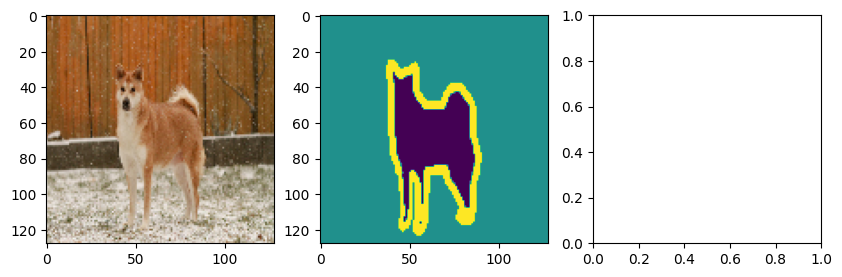

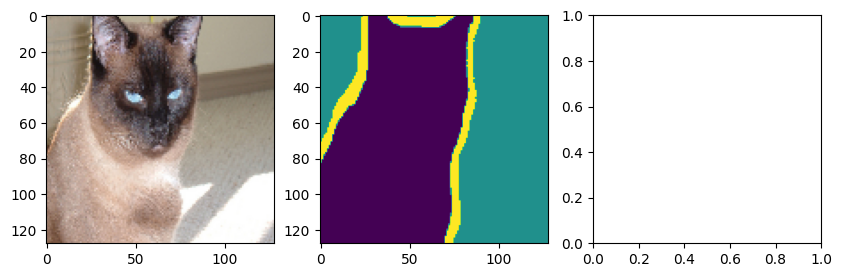

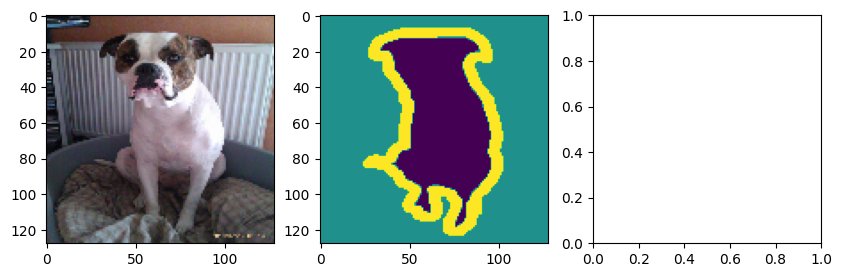

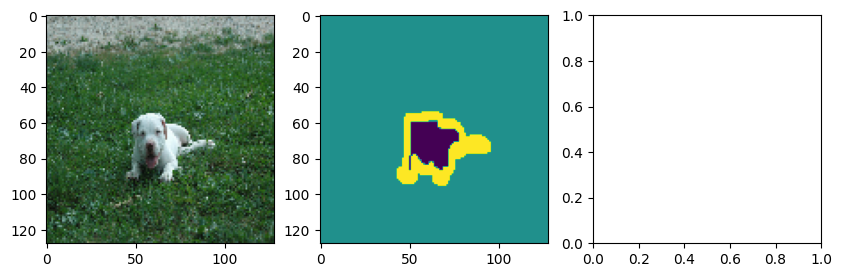

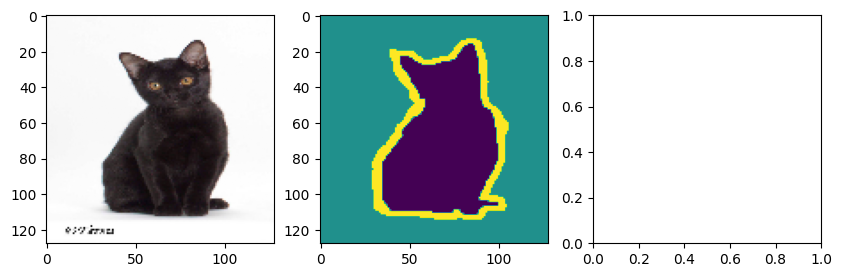

In [6]:
# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] loading up test image paths...")
imagePaths = open(config.TEST_PATHS).read().strip().split("\n")
imagePaths = np.random.choice(imagePaths, size=10)
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(config.MODEL_PATH).to(config.DEVICE)
# iterate over the randomly selected test image paths
for path in imagePaths:
	# make predictions and visualize the results
	try:
		make_predictions(unet, path)
	except:
		print(f'failed with {path}')